In [108]:
from pathlib import Path
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import config as C
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids
from features.UserJoin import UserJoin
import pandas as pd
import xgboost as xgb
import sys
%load_ext autoreload
%autoreload 2

sys.path.append('../src')
sys.path.append('../src')
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# data
ds = UserJoin()

In [124]:
print(ds.month.columns)
ds.month.index.max()

Index(['ym', 'pq_f', 'pq_g', 'pq_p', 'pq_z', 'pf', 'pg', 'pp', '   ',
       'ELEC_TYPE_NAME', 'VOLT_NAME', 'PRC_NAME', 'CONTRACT_CAP', 'RUN_CAP',
       'SHIFT_NO', 'BUILD_DATE', 'CANCEL_DATE', 'CHK_CYCLE', 'LAST_CHK_DATE',
       'TMP_NAME', 'TMP_DATE', 'IS_FLAG', 'label', 'p_f', 'p_g', 'f_g',
       'monthcv'],
      dtype='object')


2880712108

In [126]:
df = ds.month.copy()


idmax = df.index.max()
d = df[df.IS_FLAG == 1]
p = d[['pq_f', 'pq_p', 'pq_g', 'pq_z']] * .1

newdfs = []
for i in range(-5, 10):
    newd = d.copy()

    newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] = newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] + p*i
    newd = newd.reset_index()
    newd.id = newd.id + idmax*(i+6)
    newd = newd.set_index('id')

    # newt = pd.concat([df, newd])
    # newt.index.max()

    newdfs.append(newd)

t = pd.concat(newdfs + [df])
t


,ym,pq_f,pq_g,pq_p,pq_z,pf,pg,pp,,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE,IS_FLAG,label,p_f,p_g,f_g,monthcv
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
3210545919,2020-01-01,"2,343.500","2,342.500","2,341.500","7,027.500",0.333,0.333,0.333,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.000,0.000,0.000
3210545919,2020-02-01,"1,516.500","1,532.000","1,522.000","4,570.500",0.332,0.335,0.333,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.001,0.002,0.003,0.005
3210545919,2020-03-01,"2,012.500","1,961.000","2,014.000","5,987.500",0.336,0.328,0.336,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.009,0.009,0.015
3210545919,2020-04-01,892.000,883.500,891.500,"2,667.000",0.334,0.331,0.334,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.003,0.003,0.005
3210545919,2020-05-01,58.500,55.000,66.000,179.500,0.326,0.306,0.368,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.042,0.061,0.019,0.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880712108,2021-06-01,474.000,675.000,0.000,"1,149.000",0.413,0.587,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.413,0.587,0.175,0.905
2880712108,2021-07-01,342.000,881.000,0.000,"1,223.000",0.280,0.720,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.280,0.720,0.441,1.090
2880712108,2021-08-01,293.000,772.000,0.000,"1,065.000",0.275,0.725,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.275,0.725,0.450,1.098


In [143]:
# 把测试集 550 个之外的，都标为 0。可以标 14827个用户。虽然其中有2个实际是挖矿用户。但比例很小，应该无所谓。好处更大
testids = load_ids('base_551_35.csv')


def aug1(df):
    df = df.copy()
    df.loc[df.index.isin(testids), 'IS_FLAG'] = 0
    return df


# 把挖矿用户按比例变化，1个变成10个
def aug2(df):
    idmax = df.index.max()

    d = df[df.IS_FLAG == 1]
    p = d[['pq_f', 'pq_p', 'pq_g', 'pq_z']] * .002

    newdfs = []
    for i in range(-400, 500):
        newd = d.copy()

        newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] = newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] + p*i
        newd = newd.reset_index()
        newd.id = newd.id + idmax*(i+6)
        newd = newd.set_index('id')

        newdfs.append(newd)

    return pd.concat(newdfs + [df])


def fix_user_month(df):
    df = df.copy()
    # 2294741747 2020 七月之前
    # 2825771263 2020 三月之前
    df.loc[(df.index == 2294741747) & (df.ym < '2020-07'), 'IS_FLAG'] = 0
    df.loc[(df.index == 2825771263) & (df.ym < '2020-03'), 'IS_FLAG'] = 0
    return df


def info(f):
    target = load_ids(f)
    for i in Path('submit_csv').glob('base*.csv'):
        cmp = load_ids(i.name)
        print(i.name, target - cmp, len(target & cmp))


In [129]:
month = ds.month
# month = ds.rule1(ds.month)
month = month[C.month_features + ['IS_FLAG', 'label', 'ym']]
user = ds.train[C.user_features]

user_about_month = [i for i in user.columns if i in month.columns]
monthjoin = month.join(user[user_about_month], rsuffix='_mean')

mean_cols = []
for i in monthjoin.columns:
    if 'mean' in i:
        monthjoin[i.replace('mean', 'sub_mean')] = monthjoin[i.replace('_mean', '')] - monthjoin[i]
        mean_cols.append(i)

monthjoin = monthjoin.drop(columns=mean_cols)


In [130]:
from xgboost import plot_tree
# df = monthjoin[monthjoin.index.isin(ds.train2.index.values)]
# df = month
# [['pp', 'pf', 'pg',  'monthcv', 'IS_FLAG', 'label']]
df = monthjoin
print((~df.IS_FLAG.isna()).sum())
df = fix_user_month(df)
df = aug2(df)
print(df[~df.IS_FLAG.isna()].groupby('IS_FLAG').count().ym)
features = list(set(df.columns.values) - {'IS_FLAG', 'label', 'ym'})
print(features)

xy, x_val = df.loc[~df.IS_FLAG.isna(), features+['IS_FLAG']], df.loc[df.label == 'test', features]
x, y = xy[features], xy.IS_FLAG

params = {
    'n_estimator': 20,
    # 'learning_rate': .3,
    # 'max_depth': 4
}
model = xgb.XGBClassifier(**params)
#   learning_rate=.2,
#   min_child_weight=1,
#   subsample=.8,
#   colsample_bytree=.8,
#   seed=23)
model.fit(x, y)
y_pred = model.predict(x)
print((y_pred != y).sum())
# fig, ax = plt.subplots(figsize=(32, 16))
# plot_tree(model, ax=ax, rankdir='LR', num_trees=0)


185640
IS_FLAG
0.000    185438
1.000    182002
Name: ym, dtype: int64
['pq_p_sub_mean', 'pp', 'monthcv_sub_mean', 'pg_sub_mean', 'pf', 'pq_g_sub_mean', 'monthcv', 'p_g_sub_mean', 'f_g', 'pq_g', 'pp_sub_mean', 'pg', 'pq_f_sub_mean', 'pq_p', 'pq_z_sub_mean', 'pf_sub_mean', 'p_f_sub_mean', 'f_g_sub_mean', 'p_g', 'pq_f', 'pq_z', 'p_f']
[15:07:58] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[15:07:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


In [132]:
pred = pd.DataFrame({'id': x.index.values, 'pred': y_pred.astype(int)}).groupby('id').sum()
pred = pred[pred.pred > 0]
# print(pred.shape)
pred

,pred
id,
-1134670736741,21
-1133002234835,21
-1132705828805,15
-1132517894960,21
-1132386013610,21
...,...
1457414599578,21
1457434178201,21
1457455062253,21


<AxesSubplot:>

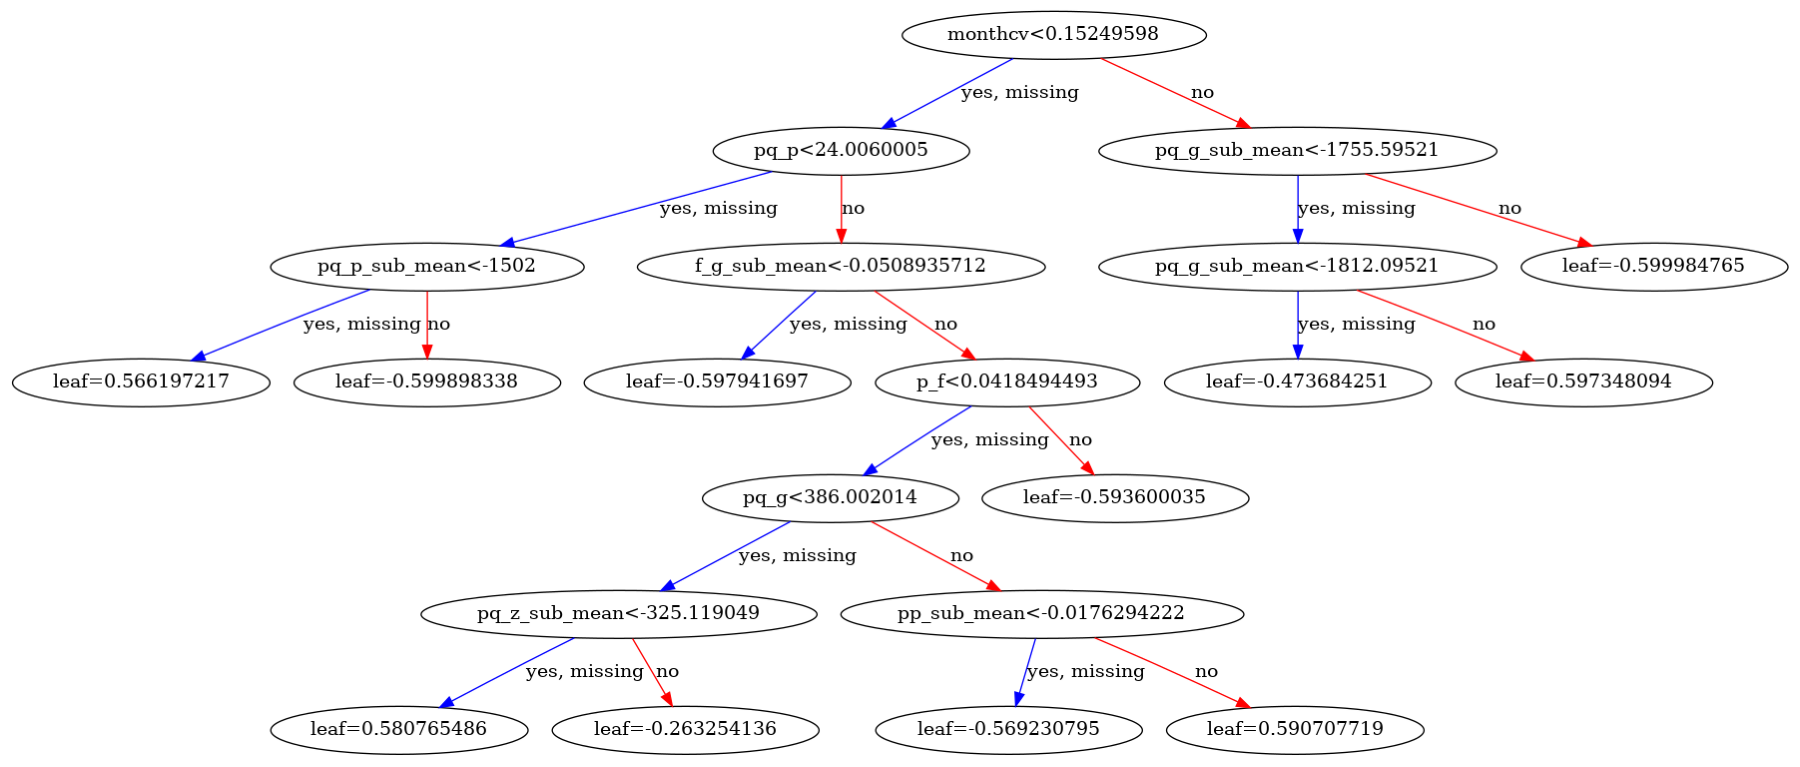

In [133]:
fig, ax = plt.subplots(figsize=(32, 16))
plot_tree(model, ax=ax)

             pred
id               
179433516  18.000
1990279480 15.000
2499757597 15.000
(28, 1)


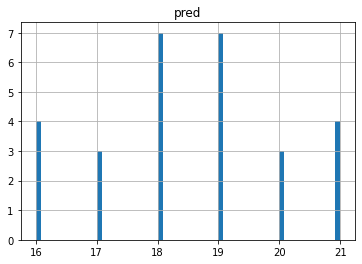

28
base_105_33.csv {179433516} 27
base_37_27.csv {2602819207, 179433516, 1862415085, 2624797677, 874996400, 2115712219, 1868919231} 21
base_182_34.csv {179433516} 27
base_551_35.csv {179433516} 27
base_68_29.csv {179433516, 1862415085} 26
base_34_27.csv {2852503463, 1862415085, 2624797677, 874996400, 2533183958, 2115712219, 2268548573, 1868919231} 20
base_39_27.csv {874996400, 1862415085, 1868919231} 25
base_35_24.csv {874996400, 1862415085, 2238809293, 1868919231} 24


In [147]:
y_val = model.predict(x_val)
pred = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
print(pred[pred.index.isin([179433516, 1990279480, 2499757597])])
pred = pred[pred.pred > 15]
print(pred.shape)
pred.hist(bins=60)
plt.show()

submit(pred.index.unique(), 'tsubmit_3_10_1.csv')
info('tsubmit_3_10_1.csv')
# s1, s2 = info('submit_3_7_1.csv')


In [154]:
target = list(load_ids('tsubmit_3_10_1.csv'))
print(len(target))

for i in Path('submit_csv').glob('base*.csv'):
    print(i.name, set(target) - load_ids(i.name))

i = set(target) - {179433516}

# plt_month(list(i), ds.month)
plt_month(list(i), ds.month, cols=['pq_f', 'pq_p', 'pq_g', 'pq_z'])

plt_day(list(i), ds.day)
plt_day(list(i), ds.day, cols=['kwh_pap_r2', 'kwh_pap_r3', 'kwh_pap_r4', 'kwh_pap_r1', 'kwh'])


[179433516, 2251440776, 2852503463] + [2115712219, 2268548573, 2535198432, 2256064355, 2471562086, 1862415085, 2624797677, 2717225077]

28
base_105_33.csv {179433516}
base_37_27.csv {2602819207, 179433516, 1862415085, 2624797677, 874996400, 2115712219, 1868919231}
base_182_34.csv {179433516}
base_551_35.csv {179433516}
base_68_29.csv {179433516, 1862415085}
base_34_27.csv {2852503463, 1862415085, 2624797677, 874996400, 2533183958, 2115712219, 2268548573, 1868919231}
base_39_27.csv {874996400, 1862415085, 1868919231}
base_35_24.csv {874996400, 1862415085, 2238809293, 1868919231}
[179458306, 2479963778, 2212416005, 2602819207, 2251440776, 1606708811, 2238809293, 2759232590, 2186749200, 2347718608, 2347718610, 2445049876, 2523401557, 2533183958, 2427050072, 2115712219, 179569820, 2268548573, 2535198432, 2256064355]


[2471562086, 2852503463, 1862415085, 2624797677, 874996400, 2717225077, 1868919231]


[179458306, 2479963778, 2212416005, 2602819207, 2251440776, 1606708811, 2238809293, 2759232590, 2186749200, 2347718608, 2347718610, 2445049876, 2523401557, 2533183958, 2427050072, 2115712219, 179569820, 2268548573, 2535198432, 2256064355]


[2471562086, 2852503463, 1862415085, 2624797677, 874996400, 2717225077, 1868919231]


[179458306, 2479963778, 2212416005, 2602819207, 2251440776, 1606708811, 2238809293, 2759232590, 2186749200, 2347718608, 2347718610, 2445049876, 2523401557, 2533183958, 2427050072, 2115712219, 179569820, 2268548573, 2535198432, 2256064355]


[2471562086, 2852503463, 1862415085, 2624797677, 874996400, 2717225077, 1868919231]


[179433516,
 2251440776,
 2852503463,
 2115712219,
 2268548573,
 2535198432,
 2256064355,
 2471562086,
 1862415085,
 2624797677,
 2717225077]

In [106]:
fs = list(Path('submit_csv').glob('base*.csv'))
for i, f1 in enumerate(fs):
    for j in range(i+1, len(fs)):
        f2 = fs[j]
        s1 = load_ids(f1.name)
        s2 = load_ids(f2.name)
        if len(s1) > 100 or len(s2) > 100 or ('68' in f1.name) or ('68' in f2.name):
            continue
        print(f1.name, f2.name, len(s1), len(s2), len(s1|s2))

base_37_27.csv base_34_27.csv 37 34 44
base_37_27.csv base_39_27.csv 37 39 45
base_37_27.csv base_35_24.csv 37 35 43
base_34_27.csv base_39_27.csv 34 39 45
base_34_27.csv base_35_24.csv 34 35 42
base_39_27.csv base_35_24.csv 39 35 43


In [ ]:
# 2294741747 2020 七月之前
# 2825771263 2020 三月之前
# plt_month(C.minerids, ds.month)
# i = [179433516] + target
# i = list(set(target) - {179433516} )
i = set(target) - load_ids('base_34_27.csv')